In [ ]:
pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
pip install seaborn matplotlib

In [ ]:
pip install sastrawi
pip install seaborn matplotlib
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from string import punctuation
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB

Dataset

In [ ]:
tokopedia_reviews = pd.read_csv("product_reviews_dirty.csv", sep=',', header='infer')
tokopedia_reviews.columns = ['id','text','rating','category','product_name', 'product_id', 'sold', 'shop_id', 'url']
print(tokopedia_reviews.head(10))

   id                                               text  rating     category  \
0   1             Barang sesuai pesanan dan cepat sampai       5  pertukangan   
1   2                           Barang bagus harga murah       5  pertukangan   
2   3    Paket rapi...mantap....cepat....sampe ke tujuan       5  pertukangan   
3   4                         ya saya puas dgn barangnya       5  pertukangan   
4   5                       Responya luar biasa b mantap       5  pertukangan   
5   6            seller top, pengiriman cepat barang oke       5  pertukangan   
6   7                        pengiriman cepat seller top       5  pertukangan   
7   8  Produk sesuai dengan spec di web dan respon se...       5  pertukangan   
8  10  Respon super cepat, pengiriman cepat, Barang b...       5  pertukangan   
9  11                     Barang mantap, pelayanan cepat       5  pertukangan   

                                        product_name  product_id sold  \
0  Staples Dekorasi Staples Kayu + 

Pre Processing

In [ ]:
class Preprocessing:
    def __init__(self):
        self.factory = StemmerFactory()
        self.stemmer = self.factory.create_stemmer()

    def processtext(self, text):
        text = text.lower()
        text = re.sub(r'\&\w*;', '', text)
        text = re.sub('@[^\s]+', '', text)
        text = re.sub(r'\$\w*', '', text)
        text = text.lower()
        text = re.sub(r'https?:\/\/.*\/\w*', '', text)
        text = re.sub(r'#\w*', '', text)
        text = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)
        text = re.sub(r'\s\s+', ' ', text)
        text = text.lstrip(' ')
        text = ''.join(c for c in text if c <= '\uFFFF')
        return text

    def stem(self, text):
        text = self.stemmer.stem(text)
        return text

    def remove_stopwords(self, param):
        f = "id_stopwords.txt"
        with open(f, 'r') as my_stopwords:
            stopwords_list = my_stopwords.read()
            word_list = param.split()
            filtered_words = [word for i, word in enumerate(word_list) if word not in stopwords_list]
            result_text = ' '.join(filtered_words)
            return result_text

In [ ]:
# ...
pr = Preprocessing()

# Memanggil metode pada kolom 'text' dari DataFrame
tokopedia_reviews['text'] = tokopedia_reviews['text'].apply(pr.processtext)
tokopedia_reviews['text'] = tokopedia_reviews['text'].apply(pr.stem)
tokopedia_reviews['text'] = tokopedia_reviews['text'].apply(lambda x: pr.remove_stopwords(x))

# Menampilkan beberapa baris awal DataFrame setelah pemrosesan
print(tokopedia_reviews.iloc[:, :3])


          id                                               text  rating
0          1                          barang sesuai pesan cepat       5
1          2                           barang bagus harga murah       5
2          3                      paket rapi mantap cepat sampe       5
3          4                                    puas dgn barang       5
4          5                                    responya mantap       5
...      ...                                                ...     ...
40602  40889                                         tutup ukur       1
40603  40890  jual krg peduli brg jelek brg kirim peyot pega...       1
40604  40891  layan sigap berhari2 smpe kasi resi valid krn ...       1
40605  40892  barang kirim tsk sesuai wrn wrn tdk ready orde...       1
40606  40893  jual respon buruk beli jual periksa barang ord...       1

[40607 rows x 3 columns]


In [ ]:
tokopedia_reviews = tokopedia_reviews[['text', 'rating']]
print(tokopedia_reviews.iloc[:10, :])

                                                text  rating
0                          barang sesuai pesan cepat       5
1                           barang bagus harga murah       5
2                      paket rapi mantap cepat sampe       5
3                                    puas dgn barang       5
4                                    responya mantap       5
5                  seller top kirim cepat barang oke       5
6                             kirim cepat seller top       5
7  produk sesuai spec web respon seller cepat tha...       5
8  respon super cepat kirim cepat barang bagus se...       5
9                          barang mantap layan cepat       5


Pelabelan dataset

In [ ]:
tokopedia_reviews.loc[tokopedia_reviews['rating'] >= 4, 'label'] = True
tokopedia_reviews.loc[tokopedia_reviews['rating'] < 4, 'label'] = False
tokopedia_reviews.to_csv('tokopedia_cleaned.csv', header=True, index=False, encoding='utf-8')
print(tokopedia_reviews)

                                                    text  rating  label
0                              barang sesuai pesan cepat       5   True
1                               barang bagus harga murah       5   True
2                          paket rapi mantap cepat sampe       5   True
3                                        puas dgn barang       5   True
4                                        responya mantap       5   True
...                                                  ...     ...    ...
40602                                         tutup ukur       1  False
40603  jual krg peduli brg jelek brg kirim peyot pega...       1  False
40604  layan sigap berhari2 smpe kasi resi valid krn ...       1  False
40605  barang kirim tsk sesuai wrn wrn tdk ready orde...       1  False
40606  jual respon buruk beli jual periksa barang ord...       1  False

[40607 rows x 3 columns]


<ipython-input-8-b5bcc14b1f7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokopedia_reviews.loc[tokopedia_reviews['rating'] >= 4, 'label'] = True


TfidfVectorizer

In [ ]:
# Misalkan kolom 'text' pada DataFrame berisi teks yang ingin dijadikan data latihan
text_data = tokopedia_reviews['text']
ratings = tokopedia_reviews['rating']

# Inisialisasi TfidfVectorizer dengan konfigurasi ngram_range=(1,1)
tf_idf = TfidfVectorizer(ngram_range=(1, 1))

# Melatih TfidfVectorizer menggunakan data teks
X_tf_idf = tf_idf.fit_transform(text_data)

# Dapatkan representasi TF-IDF dari data teks
tfidf_matrix = X_tf_idf.toarray()

Parameter multinomial

[1 1 1 ... 1 1 1]
Naive Bayes:
Precision: 0.9339599307444967
Recall: 0.9978858350951374
F1-Score: 0.9648652101699247
Accuracy: 0.9322826889928589


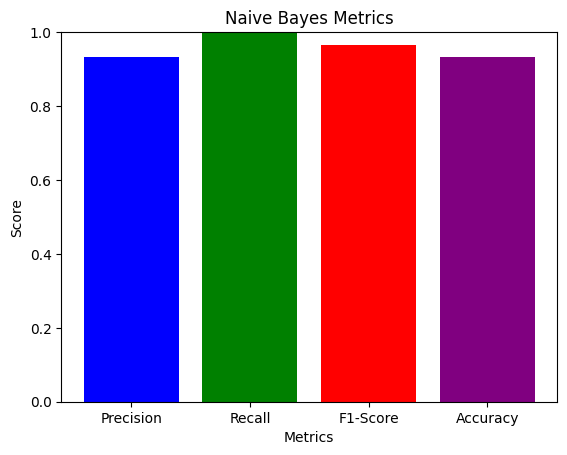

In [ ]:
# Inisialisasi target untuk klasifikasi
y_tf_idf = tokopedia_reviews['label']
y_tf_idf = y_tf_idf.astype(int)

# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_tf_idf, test_size=0.1, random_state=50)

# Melakukan oversampling menggunakan RandomOverSampler
ros = RandomOverSampler(random_state=50)
X_resampled, y_resampled = ros.fit_resample(X_tf_idf, y_tf_idf)

# Inisialisasi dan melatih model Naive Bayes
algorithm = MultinomialNB()
model = algorithm.fit(X_train, y_train)

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menampilkan hasil prediksi
print(model_pred)

# ...

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menghitung precision, recall, dan f1-score
precision = precision_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)
f1 = f1_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)

# Menampilkan hasil
print("Naive Bayes:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

# Visualisasi diagram batang
metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
metrics_values = [precision, recall, f1, accuracy]

plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple'])
plt.title('Naive Bayes Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.show()


In [ ]:
# Inisialisasi target untuk klasifikasi
y_tf_idf = tokopedia_reviews['label']
y_tf_idf = y_tf_idf.astype(int)

# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_tf_idf, test_size=0.2, random_state=50)

# Melakukan oversampling menggunakan RandomOverSampler
ros = RandomOverSampler(random_state=50)
X_resampled, y_resampled = ros.fit_resample(X_tf_idf, y_tf_idf)

# Inisialisasi dan melatih model Naive Bayes
algorithm = MultinomialNB()
model = algorithm.fit(X_train, y_train)

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menampilkan hasil prediksi
print(model_pred)

# ...

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menghitung precision, recall, dan f1-score
precision = precision_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)
f1 = f1_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)

# Menampilkan hasil
print("Naive Bayes:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")


[1 1 1 ... 1 1 1]
Naive Bayes:
Precision: 0.9343390626932113
Recall: 0.9978869519281564
F1-Score: 0.9650680120058751
Accuracy: 0.932652056143807


In [ ]:
# Inisialisasi target untuk klasifikasi
y_tf_idf = tokopedia_reviews['label']
y_tf_idf = y_tf_idf.astype(int)

# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_tf_idf, test_size=0.3, random_state=50)

# Melakukan oversampling menggunakan RandomOverSampler
ros = RandomOverSampler(random_state=50)
X_resampled, y_resampled = ros.fit_resample(X_tf_idf, y_tf_idf)

# Inisialisasi dan melatih model Naive Bayes
algorithm = MultinomialNB()
model = algorithm.fit(X_train, y_train)

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menampilkan hasil prediksi
print(model_pred)

# ...

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menghitung precision, recall, dan f1-score
precision = precision_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)
f1 = f1_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)

# Menampilkan hasil
print("Naive Bayes:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")


[1 1 1 ... 1 1 1]
Naive Bayes:
Precision: 0.9345301819978589
Recall: 0.9979773107026647
F1-Score: 0.9652122140001701
Accuracy: 0.9328572601165559


In [ ]:
# Inisialisasi target untuk klasifikasi
y_tf_idf = tokopedia_reviews['label']
y_tf_idf = y_tf_idf.astype(int)

# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_tf_idf, test_size=0.4, random_state=50)

# Melakukan oversampling menggunakan RandomOverSampler
ros = RandomOverSampler(random_state=50)
X_resampled, y_resampled = ros.fit_resample(X_tf_idf, y_tf_idf)

# Inisialisasi dan melatih model Naive Bayes
algorithm = MultinomialNB()
model = algorithm.fit(X_train, y_train)

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menampilkan hasil prediksi
print(model_pred)

# ...

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menghitung precision, recall, dan f1-score
precision = precision_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)
f1 = f1_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)

# Menampilkan hasil
print("Naive Bayes:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")


[1 1 1 ... 1 1 1]
Naive Bayes:
Precision: 0.9338103756708408
Recall: 0.9989441731556025
F1-Score: 0.9652797704447632
Accuracy: 0.9329557347780583


In [ ]:
# Inisialisasi target untuk klasifikasi
y_tf_idf = tokopedia_reviews['label']
y_tf_idf = y_tf_idf.astype(int)

# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_tf_idf, test_size=0.5, random_state=50)

# Melakukan oversampling menggunakan RandomOverSampler
ros = RandomOverSampler(random_state=50)
X_resampled, y_resampled = ros.fit_resample(X_tf_idf, y_tf_idf)

# Inisialisasi dan melatih model Naive Bayes
algorithm = MultinomialNB()
model = algorithm.fit(X_train, y_train)

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menampilkan hasil prediksi
print(model_pred)

# ...

# Melakukan prediksi menggunakan model
model_pred = model.predict(X_test)

# Menghitung precision, recall, dan f1-score
precision = precision_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)
f1 = f1_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)

# Menampilkan hasil
print("Naive Bayes:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")


[1 1 1 ... 1 1 1]
Naive Bayes:
Precision: 0.9333530513654738
Recall: 0.9995776581142435
F1-Score: 0.9653308861017641
Accuracy: 0.9330181245074862


Parameter Gaussian

In [ ]:
# Inisialisasi target untuk klasifikasi
y_tf_idf = tokopedia_reviews['label']
y_tf_idf = y_tf_idf.astype(int)

# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_tf_idf, test_size=0.4, random_state=50)

# Melakukan oversampling hanya pada data latih
ros = RandomOverSampler(random_state=50)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Convert sparse matrices to dense arrays
X_train_resampled_dense = X_train_resampled.toarray()
X_test_dense = X_test.toarray()

# Inisialisasi dan melatih model Gaussian Naive Bayes
gaussian_model = GaussianNB()
gaussian_model.fit(X_train_resampled_dense, y_train_resampled)

# Melakukan prediksi menggunakan model Gaussian Naive Bayes
gaussian_pred = gaussian_model.predict(X_test_dense)

# Menghitung precision, recall, dan f1-score untuk Gaussian Naive Bayes
precision_gaussian = precision_score(y_test, gaussian_pred)
recall_gaussian = recall_score(y_test, gaussian_pred)
f1_gaussian = f1_score(y_test, gaussian_pred)
accuracy_gaussian = accuracy_score(y_test, gaussian_pred)

# Menampilkan hasil untuk Gaussian Naive Bayes
print("Gaussian Naive Bayes:")
print(f"Precision: {precision_gaussian}")
print(f"Recall: {recall_gaussian}")
print(f"F1-Score: {f1_gaussian}")
print(f"Accuracy: {accuracy_gaussian}")

Gaussian Naive Bayes:
Precision: 0.9306578009973878
Recall: 0.2586115876996173
F1-Score: 0.4047508391427834
Accuracy: 0.29034045434956596


Visualisasi

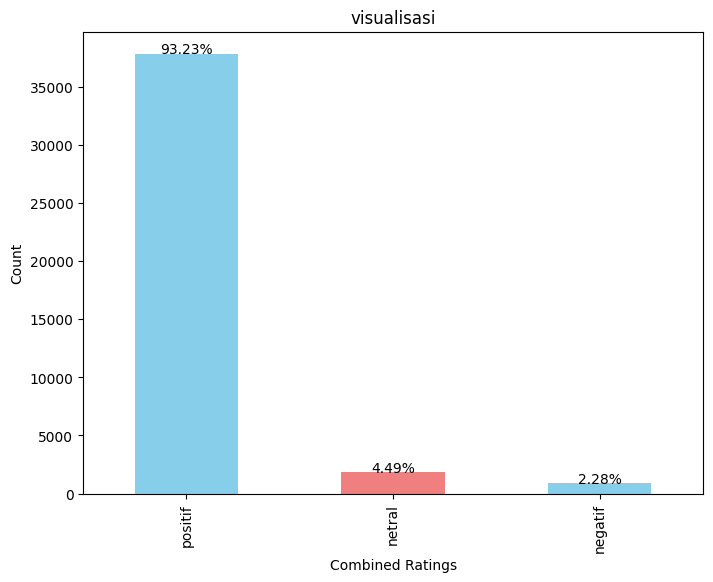

In [ ]:
tokopedia_reviews = pd.read_csv("tokopedia_cleaned.csv")
# Combine ratings 1, 2, and 3
tokopedia_reviews['combined_rating'] = tokopedia_reviews['rating'].apply(lambda x: 'positif' if x >= 4 else ('netral' if x == 3 else 'negatif'))


# Count the occurrences of each label in the combined ratings
combined_label_counts = tokopedia_reviews['combined_rating'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
combined_label_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('visualisasi')
plt.xlabel('Combined Ratings')
plt.ylabel('Count')

# Add percentage annotations
total = len(tokopedia_reviews)
for i, count in enumerate(combined_label_counts):
    percentage = (count / total) * 100
    plt.text(i, count + 0.1, f'{percentage:.2f}%', ha='center')

plt.show()
